In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import auc

In [106]:
# Import results
path = "./results"
results = os.listdir(path)
results

['compl217-s1.csv',
 'compl217-eps0.001.csv',
 'compl217-eps0.1.csv',
 'compl217-s2.csv',
 'compl217-eps0.2.csv',
 'compl217-eps0.0001.csv',
 'compl217-eps0.01.csv',
 'compl217-eps0.3.csv',
 'compl217-eps1e-05.csv']

In [107]:
# Plot one result
compl = 217
p = 2
r_path = f"{path}/compl{compl}-s{p}.csv"
r = pd.read_csv(r_path)

error = r["error"]
power_bound = r["power_bound"]
power_BN = r["power_BN"]
power_CN = r["power_CN"]
power_CN_min = r["power_CN_min"]
power_CN_max = r["power_CN_max"]

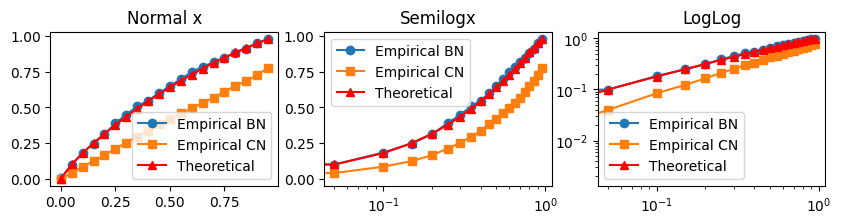

In [108]:
# Plot error vs power (empirical BN)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 2))
# ax2.set_xlim([1e-4, 0.2e1]) 
ax1.plot(error, power_BN, "-o", label = 'Empirical BN')
ax2.semilogx(error, power_BN, "-o", label = 'Empirical BN')
ax3.loglog(error, power_BN, "-o", label = 'Empirical BN')

# Plot error vs power (empirical CN)
ax1.plot(error, power_CN, "-s", label = 'Empirical CN')
ax2.semilogx(error, power_CN, "-s", label = 'Empirical CN')
ax3.loglog(error, power_CN, "-s", label = 'Empirical CN')

# Plot error vs power (theoretical)
ax1.plot(error, power_bound, "r-^", label = 'Theoretical')
ax2.semilogx(error, power_bound, "r-^", label = 'Theoretical')
ax3.loglog(error, power_bound, "r-^", label = 'Theoretical')

# Plot info
ax1.set(title='Normal x')
ax2.set(title='Semilogx')
ax3.set(title='LogLog')

ax1.legend()
ax2.legend()
ax3.legend()

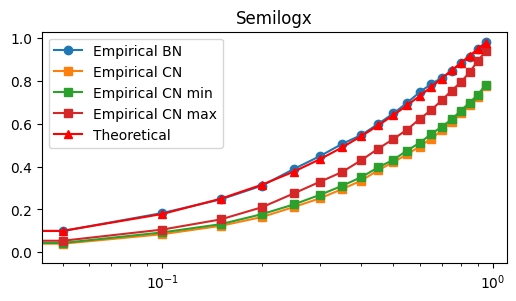

In [ ]:
# Plot error vs power (empirical BN)
fig, ax2 = plt.subplots(1,1, figsize=(6, 3))
# ax2.set_xlim([1e-4, 0.2e1]) 
ax2.semilogx(error, power_BN, "-o", label = 'Empirical BN')

# Plot error vs power (empirical CNs)
ax2.semilogx(error, power_CN, "-s", label = 'Empirical CN')
ax2.semilogx(error, power_CN_min, "-s", label = 'Empirical CN min')
ax2.semilogx(error, power_CN_max, "-s", label = 'Empirical CN max')

# Plot error vs power (theoretical)
ax2.semilogx(error, power_bound, "r-^", label = 'Theoretical')

# Plot info
ax2.set(title='Semilogx')

ax2.legend()

In [110]:
print(f"BN ROC: {auc(r['error'], r['power_BN'])}")
print(f"CN ROC: {auc(r['error'], r['power_CN'])}")

BN ROC: 0.5557472989195678
CN ROC: 0.37123349339735884
